<a href="https://colab.research.google.com/github/stephen-lin-0/NYC-Taxi/blob/master/460_Final_Project_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Import

This notebook and enviroment is completely hosted on the cloud, and downloads the required files to your Google Drive.  To replicate this analysis:

1.   Make a copy of this Notebook to your Drive, and work in the new copy.
2.   Enter this competition https://www.kaggle.com/c/nyc-taxi-trip-duration/data by clicking on Late Submission.
3.   Download your Kaggle API token by going to My Account -> Create New API Token


In [20]:
! pip install -q kaggle

# Choose the kaggle.json file that you downloaded
from google.colab import files
files.upload()

# Make directory named kaggle and copy kaggle.json file there.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

# Check on data
! kaggle datasets list


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
kimjihoo/coronavirusdataset                                 Coronavirus-Dataset                                  32KB  2020-03-12 19:16:41          11244  
sudalairajkumar/novel-corona-virus-2019-dataset             Novel Corona Virus 2019 Dataset                     348KB  2020-03-12 10:57:12          37372  
paultimothymooney/coronavirus-genome-sequence               Coronavirus Genome Sequence                           9MB  2020-02-29 00:25:13            128  
rupals/gpu-runtime                                          Segmentation GPU Kernel Performance Dataset           4MB  202

In [0]:
# download the Kaggle data to the remote machine
!kaggle competitions download -c nyc-taxi-trip-duration

  0% 0.00/2.49M [00:00<?, ?B/s]
100% 2.49M/2.49M [00:00<00:00, 83.1MB/s]
 25% 5.00M/20.3M [00:00<00:00, 38.3MB/s]
100% 20.3M/20.3M [00:00<00:00, 80.7MB/s]
 91% 57.0M/62.9M [00:00<00:00, 57.8MB/s]
100% 62.9M/62.9M [00:00<00:00, 99.1MB/s]


In [47]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition
from scipy import stats
from sklearn import cluster
from sklearn.neighbors import KNeighborsClassifier
% matplotlib inline
# check current working directory for file traversal
print(os.getcwd())

/content


In [0]:
#unzip the training files
!unzip -qq /content/train.zip -d /content/ 

In [0]:
#unzip the test files
!unzip -qq /content/test.zip -d /content/ 

In [0]:
df_taxi = pd.read_csv("train.csv")

In [26]:
df_taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,07:35
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,11:03
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,35:24
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,07:09
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,07:15


Dictionary


*   id - a unique identifier for each trip
*   pickup_datetime - date and time when the meter was engaged
*   pickup_datetime - date and time when the meter was engaged
*   dropoff_datetime - date and time when the meter was disengaged
*   passenger_count - the number of passengers in the vehicle (driver entered value)
*   pickup_longitude - the longitude where the meter was engaged
*   pickup_latitude - the latitude where the meter was engaged
*   dropoff_longitude - the longitude where the meter was disengaged
*   dropoff_latitude - the latitude where the meter was disengaged
*   store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
*   trip_duration - duration of the trip in seconds

In [34]:
df_taxi['pickup_datetime']=pd.to_datetime(df_taxi['pickup_datetime'],errors='coerce')
df_taxi['trip_duration_minutes'] = pd.to_datetime(df_taxi.trip_duration, unit='s').dt.strftime('%M:%S')
df_taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_minutes
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,07:35
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,11:03
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,35:24
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,07:09
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,07:15


In [0]:
df_taxi.pickup_datetime = pd.to_datetime(df_taxi.pickup_datetime)
df_taxi.dropoff_datetime = pd.to_datetime(df_taxi.dropoff_datetime)

In [0]:
df_taxi.dropna(how='any', axis='rows', inplace=True)

# Removing observations with erroneous values
mask = df_taxi['pickup_longitude'].between(-75, -73)
mask &= df_taxi['dropoff_longitude'].between(-75, -73)
mask &= df_taxi['pickup_latitude'].between(40, 42)
mask &= df_taxi['dropoff_latitude'].between(40, 42)
mask &= df_taxi['passenger_count'].between(0, 8)
mask &= df_taxi['trip_duration'].between(60,7200)

df_taxi = df_taxi[mask]

In [0]:
#Do we need

#df_taxi['mm_pickup'] = df_taxi.pickup_datetime.dt.month.astype(np.uint8)
#df_taxi['mm_dropoff'] = df_taxi.dropoff_datetime.dt.month.astype(np.uint8)

    # day of week
#df_taxi['dow_pickup'] = df_taxi.pickup_datetime.dt.weekday.astype(np.uint8)
#df_taxi['dow_dropoff'] = df_taxi.dropoff_datetime.dt.weekday.astype(np.uint8)

    # day hour
#df_taxi['hh_pickup'] = df_taxi.pickup_datetime.dt.hour.astype(np.uint8)
#df_taxi['hh_dropoff'] = df_taxi.dropoff_datetime.dt.hour.astype(np.uint8)

In [0]:
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) 

In [0]:
df_taxi['distance_miles'] = distance(df_taxi.pickup_latitude, df_taxi.pickup_longitude, \
                                      df_taxi.dropoff_latitude, df_taxi.dropoff_longitude)

In [40]:
df_taxi.groupby('passenger_count')['distance_miles', 'trip_duration_minutes'].mean()

,distance_miles
passenger_count,
0,2.704759
1,2.112432
2,2.272540
3,2.196573
4,2.257069
5,2.181611
6,2.119359
8,3.698310


Text(0.5, 1.0, 'Histogram ride time in seconds')

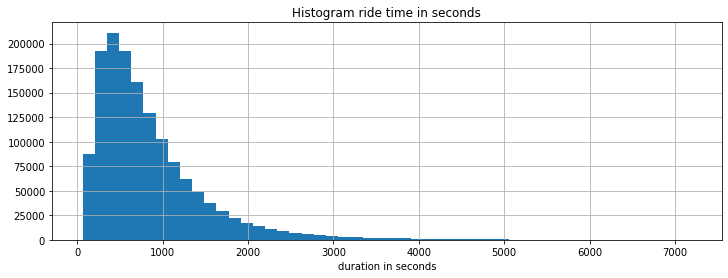

In [41]:
df_taxi.trip_duration.hist(bins=50, figsize=(12,4))
plt.xlabel('duration in seconds')
plt.title('Histogram ride time in seconds')

Text(0.5, 1.0, 'Histogram ride distances in miles')

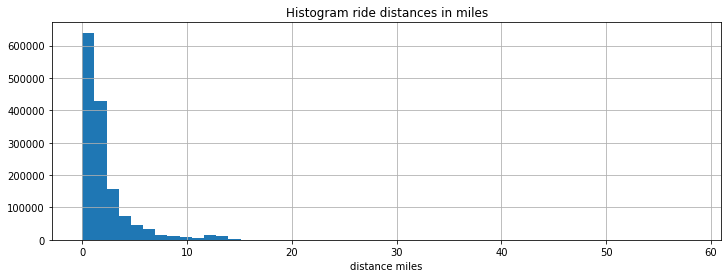

In [42]:
df_taxi.distance_miles.hist(bins=50, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')

In [0]:
boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}

In [44]:
df_taxi.loc[~((df_taxi.pickup_longitude >= boundary['min_lng'] ) & (df_taxi.pickup_longitude <= boundary['max_lng']) &
            (df_taxi.pickup_latitude >= boundary['min_lat']) & (df_taxi.pickup_latitude <= boundary['max_lat']) &
            (df_taxi.dropoff_longitude >= boundary['min_lng']) & (df_taxi.dropoff_longitude <= boundary['max_lng']) &
            (df_taxi.dropoff_latitude >=boundary['min_lat']) & (df_taxi.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=1
df_taxi.loc[((df_taxi.pickup_longitude >= boundary['min_lng'] ) & (df_taxi.pickup_longitude <= boundary['max_lng']) &
            (df_taxi.pickup_latitude >= boundary['min_lat']) & (df_taxi.pickup_latitude <= boundary['max_lat']) &
            (df_taxi.dropoff_longitude >= boundary['min_lng']) & (df_taxi.dropoff_longitude <= boundary['max_lng']) &
            (df_taxi.dropoff_latitude >=boundary['min_lat']) & (df_taxi.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=0

print("Outlier vs Non Outlier Counts")
print(df_taxi['is_outlier_loc'].value_counts())

# Let us drop rows, where location is outlier
df_taxi=df_taxi.loc[df_taxi['is_outlier_loc']==0]
df_taxi.drop(['is_outlier_loc'],axis=1,inplace=True)

Outlier vs Non Outlier Counts
0.0    1447546
1.0        208
Name: is_outlier_loc, dtype: int64


In [0]:
def PickupPlot1(data):
    '''
    Pickup time distribution by hour-of-day
    '''
    plt.figure(figsize=(12,2))

    data = data.groupby('hh_pickup').aggregate({'id':'count'}).reset_index()
    sns.barplot(x='hh_pickup', y='id', data=data)

    plt.title('Pick-ups Hour Distribution')
    plt.xlabel('Hour of Day, 0-23')
    plt.ylabel('No of Trips made')

    plt.savefig('pickups-hour-distribution.png')

def PickupPlot2(data, dow_names):
    '''
    Pickup time distribution by day-of-week
    '''
    plt.figure(figsize=(12,2))

    data = data.groupby('dow_pickup').aggregate({'id':'count'}).reset_index()
    sns.barplot(x='dow_pickup', y='id', data=data)

    plt.title('Pick-ups Weekday Distribution')
    plt.xlabel('Trip Duration, minutes')
    plt.xticks(range(0,7), dow_names, rotation='horizontal')
    plt.ylabel('No of Trips made')

    plt.savefig('pickups-weekday-distribution.png')

def PickupPlot3(data, dow_names):
    '''
    Pickup heatmap of day-of-week vs. hour-of-day
    '''
    plt.figure(figsize=(12,2))
    sns.heatmap(data=pd.crosstab(data.dow_pickup, data.hh_pickup, values=data.vendor_id, aggfunc='count', normalize='index'))

    plt.title('Pickup heatmap, Day-of-Week vs. Day Hour')
    plt.ylabel('Weekday')
    plt.xlabel('Day Hour, 0-23')
    plt.yticks(range(0,7), dow_names[::-1], rotation='horizontal')

    plt.savefig('pickup-heatmap-day-of-week-vs-hour.png')

def TripDurationPlot1(data):
    '''
    Trip duration distribution in minutes
    '''
    plt.figure(figsize=(12,3))

    plt.title('Trip Duration Distribution')
    plt.xlabel('Trip Duration, minutes')
    plt.ylabel('No of Trips made')
    plt.hist(data.trip_duration / 60, bins=100)

    plt.savefig('trip-duration-distribution.png')

def TripDurationPlot2(data, dow_names):
    '''
    Trip duration based on hour-of-day vs. weekday
    '''
    plt.figure(figsize=(12,2))
    sns.heatmap(data=pd.crosstab(data.dow_pickup, data.hh_pickup, values=data.trip_duration/60, aggfunc='mean'))

    plt.title('Trip duration heatmap (Minutes), Day-of-Week vs. Day Hour')
    plt.ylabel('Weekday')
    plt.xlabel('Day Hour, 0-23')
    plt.yticks(range(0,7), dow_names[::-1], rotation='horizontal')

    plt.savefig('trip-duration-heatmap.png')

In [52]:
if __name__ == '__main__':
    # Load train data
    taxiDB = df_taxi

    # Let's add some additional columns to speed-up calculations dow names for plot mapping
    dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Visualization for Pick-Up feature
    PickupPlot1(taxiDB)
    PickupPlot2(taxiDB, dow_names)
    PickupPlot3(taxiDB, dow_names)

    # Visualization for Trip Duration feature
    TripDurationPlot1(taxiDB)
    TripDurationPlot2(taxiDB, dow_names)

KeyError: ignored

<Figure size 864x144 with 0 Axes>

In [0]:
nyc_airports={'JFK':{'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659},
              
    'EWR':{'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        },
    'LaGuardia':{'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
        
    }
    
}
def isAirport(latitude,longitude,airport_name='JFK'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0

In [0]:
# Maybe use
#df_taxi['is_pickup_JFK']=df_taxi.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
#df_taxi['is_dropoff_JFK']=df_taxi.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)
#df_taxi['is_pickup_EWR']=df_taxi.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
#df_taxi['is_dropoff_EWR']=df_taxi.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
#df_taxi['is_pickup_la_guardia']=df_taxi.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
#df_taxi['is_dropoff_la_guardia']=df_taxi.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)

In [0]:
data = df_taxi

In [0]:
allLat = np.array(list(data['pickup_latitude']) + list(data['dropoff_latitude']))
allLong = np.array(list(data['pickup_longitude']) + list(data['dropoff_longitude']))

longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]

data = data[(data['pickup_latitude']   >= latLimits[0] ) & (data['pickup_latitude']   <= latLimits[1]) ]
data = data[(data['dropoff_latitude']  >= latLimits[0] ) & (data['dropoff_latitude']  <= latLimits[1]) ]
data = data[(data['pickup_longitude']  >= longLimits[0]) & (data['pickup_longitude']  <= longLimits[1])]
data = data[(data['dropoff_longitude'] >= longLimits[0]) & (data['dropoff_longitude'] <= longLimits[1])]
data = data.reset_index(drop=True)

allLat = np.array(list(data['pickup_latitude']) + list(data['dropoff_latitude']))
allLong = np.array(list(data['pickup_longitude']) + list(data['dropoff_longitude']))

    # convert fields to sensible units
medianLat = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

data['duration [min]'] = data['trip_duration']/60.0
data['src lat [km]']   = latMultiplier  * (data['pickup_latitude']   - medianLat)
data['src long [km]']  = longMultiplier * (data['pickup_longitude']  - medianLong)
data['dst lat [km]']   = latMultiplier  * (data['dropoff_latitude']  - medianLat)
data['dst long [km]']  = longMultiplier * (data['dropoff_longitude'] - medianLong)

allLat  = np.array(list(data['src lat [km]'])  + list(data['dst lat [km]']))
allLong = np.array(list(data['src long [km]']) + list(data['dst long [km]']))

NameError: ignored

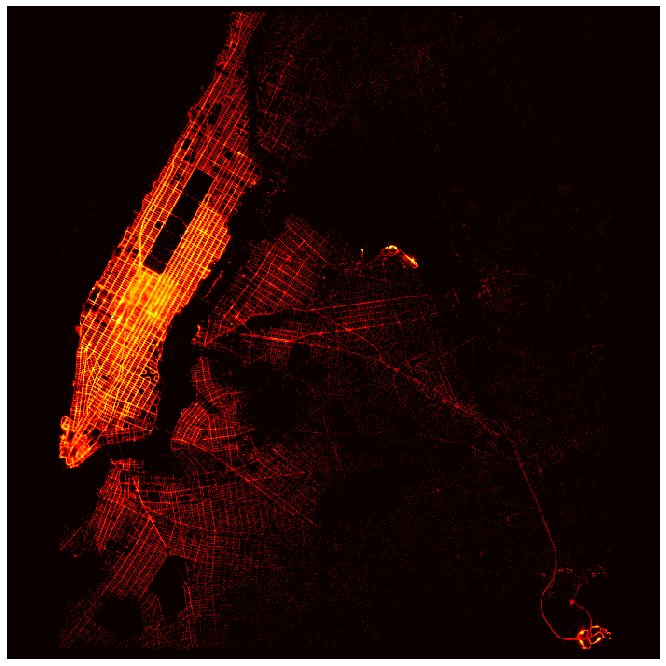

In [57]:
imageSize = (700, 700)
longRange = [-5, 19]
latRange = [-13, 11]

allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds = (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds, allLongInds):
    locationDensityImage[latInd, longInd] += 1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
ax.imshow(np.log(locationDensityImage + 1), cmap='hot')
ax.set_axis_off()

plt.savefig('spatial-density-pickup-dropoff.png')

latInds = imageSize[0] - (imageSize[0] * (latCoord  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
longInds = (imageSize[1] * (longCoord - longRange[0]) / (longRange[1] - longRange[0])).astype(int)


templateTrips = TripKmeansModel.cluster_centers_ * np.tile(stdTripAttr, (numClusters, 1)) + np.tile(meanTripAttr,(numClusters, 1))

srcCoords = templateTrips[:, :2]
dstCoords = templateTrips[:, 2:4]

srcImCoords = ConvertToImageCoords(srcCoords[:, 0],srcCoords[:, 1], latRange, longRange, imageSize)
dstImCoords = ConvertToImageCoords(dstCoords[:, 0],dstCoords[:, 1], latRange, longRange, imageSize)

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage + 1), cmap='hot')
plt.grid('off')
plt.scatter(srcImCoords[1], srcImCoords[0], c='m', s=200, alpha=0.8)
plt.scatter(dstImCoords[1], dstImCoords[0], c='g', s=200, alpha=0.8)

for i in range(len(srcImCoords[0])):
    plt.arrow(srcImCoords[1][i], srcImCoords[0][i],
            dstImCoords[1][i]-srcImCoords[1][i],
            dstImCoords[0][i]-srcImCoords[0][i],
            edgecolor='c', facecolor='c',
            width=0.8,
            alpha=0.4,
            head_width=10.0,
            head_length=10.0,
            length_includes_head=True)

plt.savefig('typical-trips.png')

In [0]:
### Source -- https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation ---- ###
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-Park slope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Upper East Side',
               -73.9453487097: 'Brooklyn-Williamsburg',-73.9745967889:'Upper West Side'}

In [59]:
rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [0]:
df_taxi['pickup_neighborhood'] = neigh.predict(df_taxi.pickup_longitude.values.reshape(-1,1))
df_taxi['dropoff_neighborhood'] = neigh.predict(df_taxi.dropoff_longitude.values.reshape(-1,1))

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df_taxi[(df_taxi.pickup_neighborhood == x) & (df_taxi.dropoff_neighborhood == col)]))

In [61]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

trace = go.Heatmap(z= np.array(rides_df.as_matrix()),
                  x = rides_df.columns[:-1],
                  y = rides_df.columns)
layout = dict(
    title = ' <b>Neighborhood Interaction</b>',
    titlefont = dict(
    size = 30,
    color = ('rgb(100,100,100)')),
    margin = dict(t=100,r=100,b=100,l=150),
        yaxis = dict(
            title = ' <b> From </b>'),
        xaxis = dict(
            title = '<b> To </b>'))
data=[trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labeled-heatmap')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



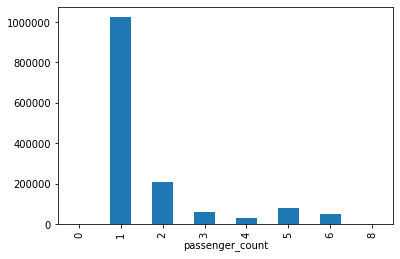

In [62]:
data_passenger = df_taxi['passenger_count'].value_counts().sort_index()
data_passenger.plot(kind='bar')
plt.xlabel('passenger_count')

plt.show()